In [8]:
from Unet import Unet
from dpm import GaussianDiffusion
import torch
from option import get_option   
from tqdm import tqdm

opt = get_option()
Unet = Unet(3, opt.num_res, opt.num_channels, opt.n, opt.scale)
ckpt = torch.load(
    "./checkpoints/is_32+s_1+n_3/epoch=11-train_psnr=62.9890.ckpt"
)["state_dict"]
for k in list(ckpt.keys()):
    if "ema" in k:
        ckpt.pop(k)
        continue
    ckpt[k.replace("diffusion.model.", "")] = ckpt.pop(k)

Unet.load_state_dict(ckpt)
Unet.eval()

Unet(
  (stem): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder): ModuleList(
    (0): Block(
      (block): SwitchSequential(
        (0): TimeResidualBlock(
          (norm1): GroupNorm(32, 128, eps=1e-05, affine=True)
          (norm2): GroupNorm(32, 256, eps=1e-05, affine=True)
          (conv1): ResidualBlock(
            (gn1): GroupNorm(32, 128, eps=1e-05, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
            (gn2): GroupNorm(32, 128, eps=1e-05, affine=True)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (gn3): GroupNorm(32, 128, eps=1e-05, affine=True)
            (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
            (residual_layer): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU()
          )
          (conv2): ResidualBlock(
            (gn1): GroupNorm(32, 256, eps=1e-05, affine=True)
            (conv

In [38]:
class GaussianDiffusion(torch.nn.Module):
    def __init__(
        self,
        model,
        beta1=1e-4,
        betaT=1e-2,
        T=1000,
        loss_type="l2",
        device=torch.device("cuda:0"),
    ):
        super().__init__()
        self.model = model.to(device)  # 将模型设置为设备
        self.loss_type = loss_type  # 设置损失类型
        self.T = T  # 初始化扩散系数的起始和结束值，以及时间步长
        self.betas = torch.linspace(beta1, betaT, T, device=device)  # 生成一个线性间隔的扩散系数向量
        self.alphas = 1 - self.betas  # 计算每个时间步的α值
        self.alphas_bar = torch.cumprod(self.alphas, dim=0)  # 计算累积乘积的α_bar值

    def get_loss(self, x_0, t):
        x_t, noise = self.get_noise_image(x_0, t)  # 获取加噪声的图像和噪声
        with torch.cuda.amp.autocast():
            predicted_noise = self.model(x_t, t)  # 使用模型预测噪声
            if self.loss_type == "l2":  # 如果损失类型为l2
                loss = F.mse_loss(predicted_noise, noise)  # 计算均方误差损失
            elif self.loss_type == "l1":  # 如果损失类型为l1
                loss = F.l1_loss(predicted_noise, noise)  # 计算L1损失
            else:
                raise ValueError("Unknown loss type")  # 如果损失类型未知，则抛出错误
        return loss

    def get_noise_image(self, x_0, t):
        sqrt_alphas_hat = torch.sqrt(self.alphas_bar[t])  # 计算sqrt(α_bar)
        sqrt_one_minus_alphas_hat = torch.sqrt(1 - self.alphas_bar[t])
        noise = torch.randn_like(x_0)  # 生成与x_0形状相同的随机噪声
        return (
            sqrt_alphas_hat.reshape(-1, 1, 1, 1) * x_0
            + sqrt_one_minus_alphas_hat.reshape(-1, 1, 1, 1) * noise,
            noise,
        )

    @torch.no_grad()
    def ddpm_sample(
        self,
        n,
        skip_step=100,
        image_size=(3, 32, 32),
        save_interval=True,
        simple_var=True,
    ):
        """
        Generate samples using the Denoising Diffusion Probabilistic Model (DDPM).

        Args:
            n (int): Number of samples to generate.
            T (int): Number of time steps.
            image_size (tuple, optional): Size of the image samples. Defaults to (3, 32, 32).
            save_interval (bool, optional): Whether to save intermediate samples at each time step. Defaults to True.

        Returns:
            torch.Tensor: Generated image samples.
            list: List of intermediate samples at each time step if save_interval is True, otherwise an empty list.
        """
        self.model.eval()  # Set the model to evaluation mode
        samples = torch.randn(n, *image_size, device=self.betas.device)
        ts = torch.linspace(
            self.T, 0, (skip_step + 1), device=self.betas.device, dtype=torch.long
        )
        if save_interval:
            interval = []
        for i in tqdm(range(1, skip_step + 1), position=0):
            cur_t = ts[i - 1] - 1
            prev_t = ts[i] - 1
            t = torch.ones(n, dtype=torch.long, device=self.betas.device) * cur_t
            predicted_noise = self.model(samples, t)  # Predict noise using the model
            alpha = self.alphas[cur_t].reshape(-1, 1, 1, 1)  # Get alpha values
            alpha_bar = self.alphas_bar[cur_t].reshape(-1, 1, 1, 1)
            alpha_bar_prev = self.alphas_bar[prev_t].reshape(-1, 1, 1, 1)
            beta = self.betas[cur_t].reshape(-1, 1, 1, 1)  # Get beta values

            if i > 1:  # If it's not the last time step
                if simple_var:
                    var = beta
                else:
                    var = (1 - alpha_bar_prev) / (1 - alpha_bar) * beta
                noise = torch.sqrt(var) * torch.randn_like(samples)
            else:
                noise = torch.zeros_like(samples)  # No noise for the last time step

            samples = (
                samples - (1 - alpha) / torch.sqrt(1 - alpha_bar) * predicted_noise
            ) / torch.sqrt(alpha) + noise

            interval.append(samples) if save_interval else 0
        return samples, interval  # Return the generated image samples

    @torch.no_grad()
    def ddim_sample(
        self,
        n,
        skip_step=100,
        image_size=(3, 32, 32),
        save_interval=True,
        eta=1,
        simple_var=True,
    ):
        """
        Generate samples using Denoising Diffusion Models.

        Args:
            n (int): Number of samples to generate.
            T (int): Number of diffusion steps.
            skip_step (int, optional): Number of steps to skip between samples. Defaults to 100.
            image_size (tuple, optional): Size of the generated image samples. Defaults to (3, 32, 32).
            save_interval (bool, optional): Whether to save intermediate samples. Defaults to True.

        Returns:
            torch.Tensor: Generated samples.
            list: List of intermediate samples if save_interval is True, otherwise an empty list.
        """
        self.model.eval()
        if simple_var:
            eta = 1
        samples = torch.randn(n, *image_size, device=self.betas.device)
        ts = torch.linspace(
            self.T, 0, (skip_step + 1), device=self.betas.device, dtype=torch.long
        )
        if save_interval:
            interval = []
        for i in tqdm(range(1, skip_step + 1), position=0):
            cur_t = ts[i - 1] - 1
            prev_t = ts[i] - 1
            t = torch.ones(n, dtype=torch.long, device=self.betas.device) * cur_t
            predicted_noise = self.model(samples, t)
            alpha_k = self.alphas_bar[cur_t].reshape(-1, 1, 1, 1)
            alpha_s = self.alphas_bar[prev_t].reshape(-1, 1, 1, 1) if prev_t >= 0 else 1
            var = eta * (1 - alpha_s) / (1 - alpha_k) * (1 - alpha_k / alpha_s)
            noise = torch.randn_like(samples)

            first_term = (alpha_s / alpha_k) ** 0.5 * samples
            second_term = (
                (1 - alpha_s - var) ** 0.5 - (alpha_s * (1 - alpha_k) / alpha_k) ** 0.5
            ) * predicted_noise
            if simple_var:
                third_term = (1 - alpha_k / alpha_s) ** 0.5 * noise
            else:
                third_term = (var) ** 0.5 * noise

            samples = first_term + second_term + third_term

            interval.append(samples) if save_interval else 0
        return samples, interval

diffusion = GaussianDiffusion(Unet, 1e-4, 1e-2, opt.T)
result = diffusion.ddim_sample(9, 10, image_size=(3, 32, 32), eta=1, simple_var=False)

100%|██████████| 10/10 [00:00<00:00, 46.18it/s]


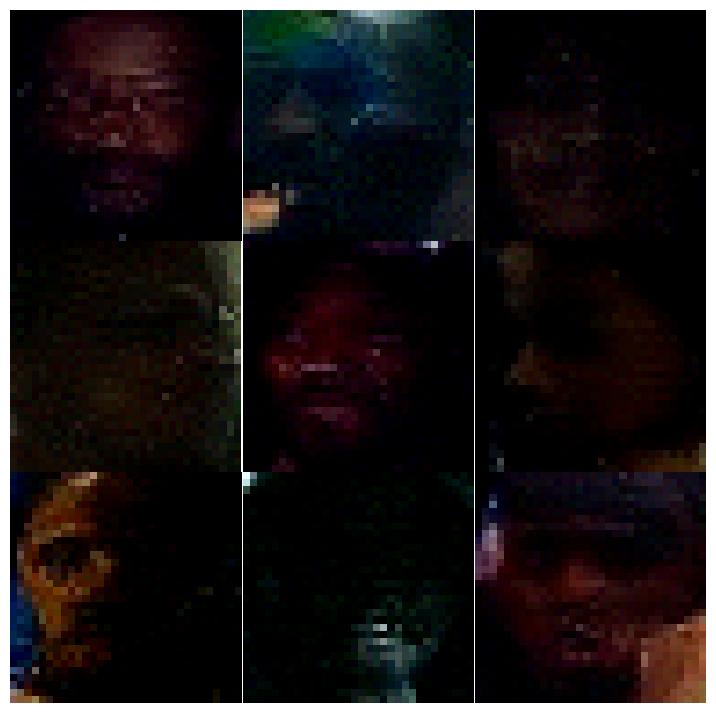

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

images = result[0]


def show(images):
    plt.rcParams["figure.figsize"] = (9.0, 9.0)
    plt.subplots_adjust(wspace=0, hspace=0)
    n = images.shape[0]
    for i in range(n):
        plt.subplot(3, 3, i + 1)
        plt.imshow(
            np.transpose(
                np.clip(
                    images[i].cpu().numpy(),
                    0,
                    1,
                ),
                (1, 2, 0),
            )
        )
        plt.axis("off")
        cv2.imwrite(
            f"./output/{i:02d}.png",
            np.transpose(255 * np.clip(images[i].cpu().numpy(), 0, 1), (1, 2, 0))[
                ..., ::-1
            ],
        )
    plt.show()


show(images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

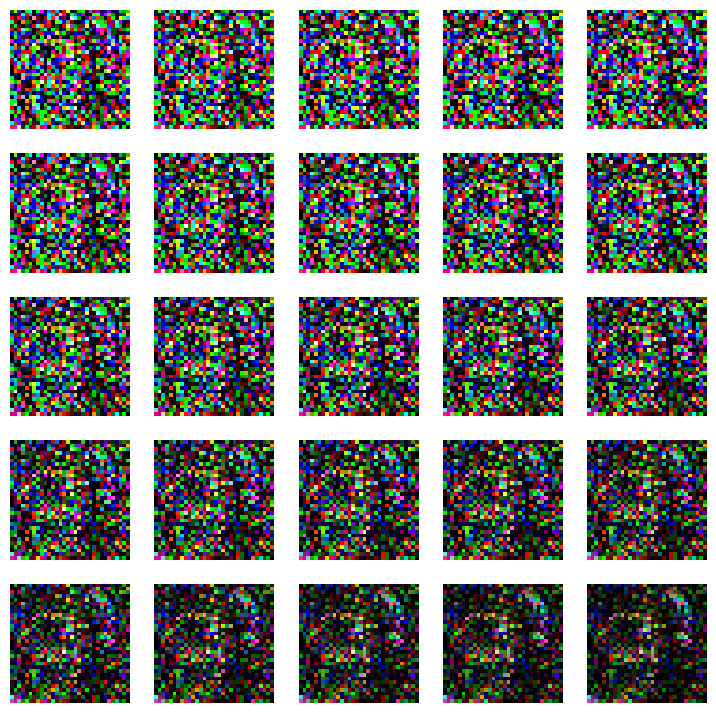

In [21]:
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(result[1][i][0].permute(1, 2, 0).cpu().numpy())
    plt.axis("off")
plt.show()